# Load Data

In [1]:
import os
import shutil
from ecg_age.src.helpers.helpers import *
from ecg_age.src.models.models import *


# 1. Make the Kaggle directory (only if it doesn't exist)
kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
os.makedirs(kaggle_dir, exist_ok=True)  

# 2. Copy your Kaggle API credentials (replace 'kaggle.json' if your file has a different name)
kaggle_json_path = r"C:\Users\Sebastian\.kaggle\kaggle.json"
os.replace(kaggle_json_path, os.path.join(kaggle_dir, "kaggle.json")) 

# 3. Verify that the file was copied
print(os.listdir(kaggle_dir))  # Should print 'kaggle.json'

# 4. Set correct permissions on the credentials file
os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)  # 0o600 means read/write for owner only


['kaggle.json']


In [4]:
import pandas as pd
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tqdm
from scipy import signal
from tensorflow import keras
#from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload
%reload_ext autoreload
sns.set_style("dark")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Collecting Label Data
Extending the headers into gender, age, labels, ecg_len and ecg_filenames

In [5]:
select_gender="both"

print("Collecting labels, ECG filenames and metadata...")
gender, age, labels, ecg_len, ecg_filenames = import_key_data("data/")
ecg_filenames = np.asarray(ecg_filenames)
age = np.asarray(age)
gender = np.asarray(gender)
ecg_len = np.asarray(ecg_len)
labels = np.asarray(labels)
print(f"Total number of patients found: {len(age)}")

100%|██████████| 111112/111112 [08:11<00:00, 226.20it/s]

Total number of patients found: 49198


In [6]:
print("remove all ECGs not equal to 10 seconds")
age, gender,ecg_filenames, labels = only_ten_sec(ecg_len, age, gender, ecg_filenames, labels)

print("remove all ECGs with missing values in gender or age")
ecg_filenames, gender, age, labels = remove_nan_and_unknown_values(ecg_filenames, gender, age, labels)

age = clean_up_age_data(age)
gender = clean_up_gender_data(gender)

print("Select ECGs from males or females")
if select_gender != "both":
    gender, age, ecg_filenames, labels = male_or_female(gender, age, ecg_filenames, labels, g=select_gender)
else:
    pass

print(f"Total number of patients left after data cleaning: {len(age)}")


remove all ECGs not equal to 10 seconds
remove all ECGs with missing values in gender or age
Select ECGs from males or females
Total number of patients left after data cleaning: 49139


In [7]:
print(f"Length of age: {len(age)}")
print(f"Length of gender: {len(gender)}")
print(f"Length of labels: {len(labels)}")
print(f"Length of ecg_filenames: {len(ecg_filenames)}")


Length of age: 49139
Length of gender: 49139
Length of labels: 49139
Length of ecg_filenames: 49139


In [8]:
ground_data = {
    'Age': age,
    'Gender': gender,
    'Labels': labels,
    'ECG Filenames': ecg_filenames

}

# Create the DataFrame
ground_data = pd.DataFrame(ground_data)
ground_data.head()

,Age,Gender,Labels,ECG Filenames
0,49,1,426783006,data/\A0002.mat
1,81,1,164889003,data/\A0003.mat
2,74,0,164889003,data/\A0007.mat
3,82,0,59118001,data/\A0010.mat
4,74,1,164889003,data/\A0019.mat


In [9]:
# Count the number of rows per label
label_counts = ground_data['Labels'].value_counts().reset_index()

# Rename the columns for better readability
label_counts.columns = ['Label', 'Count']

# Display the dataframe
label_counts.head(6)

,Label,Count
0,426177001,8909
1,426783006,6251
2,427084000,3226
3,164890007,1499
4,"426177001,55827005",1333
5,427393009,1234


In [10]:
# Filter the ground_data DataFrame to only keep the specified labels
filtered_labels = ['426177001', '426783006', '427084000', '164890007', '427393009']
ground_data_filtered = ground_data[ground_data['Labels'].isin(filtered_labels)]

# Print the number of rows per label
label_counts = ground_data_filtered['Labels'].value_counts()
print(label_counts)

Labels
426177001    8909
426783006    6251
427084000    3226
164890007    1499
427393009    1234
Name: count, dtype: int64


# Visualizing the Dataset

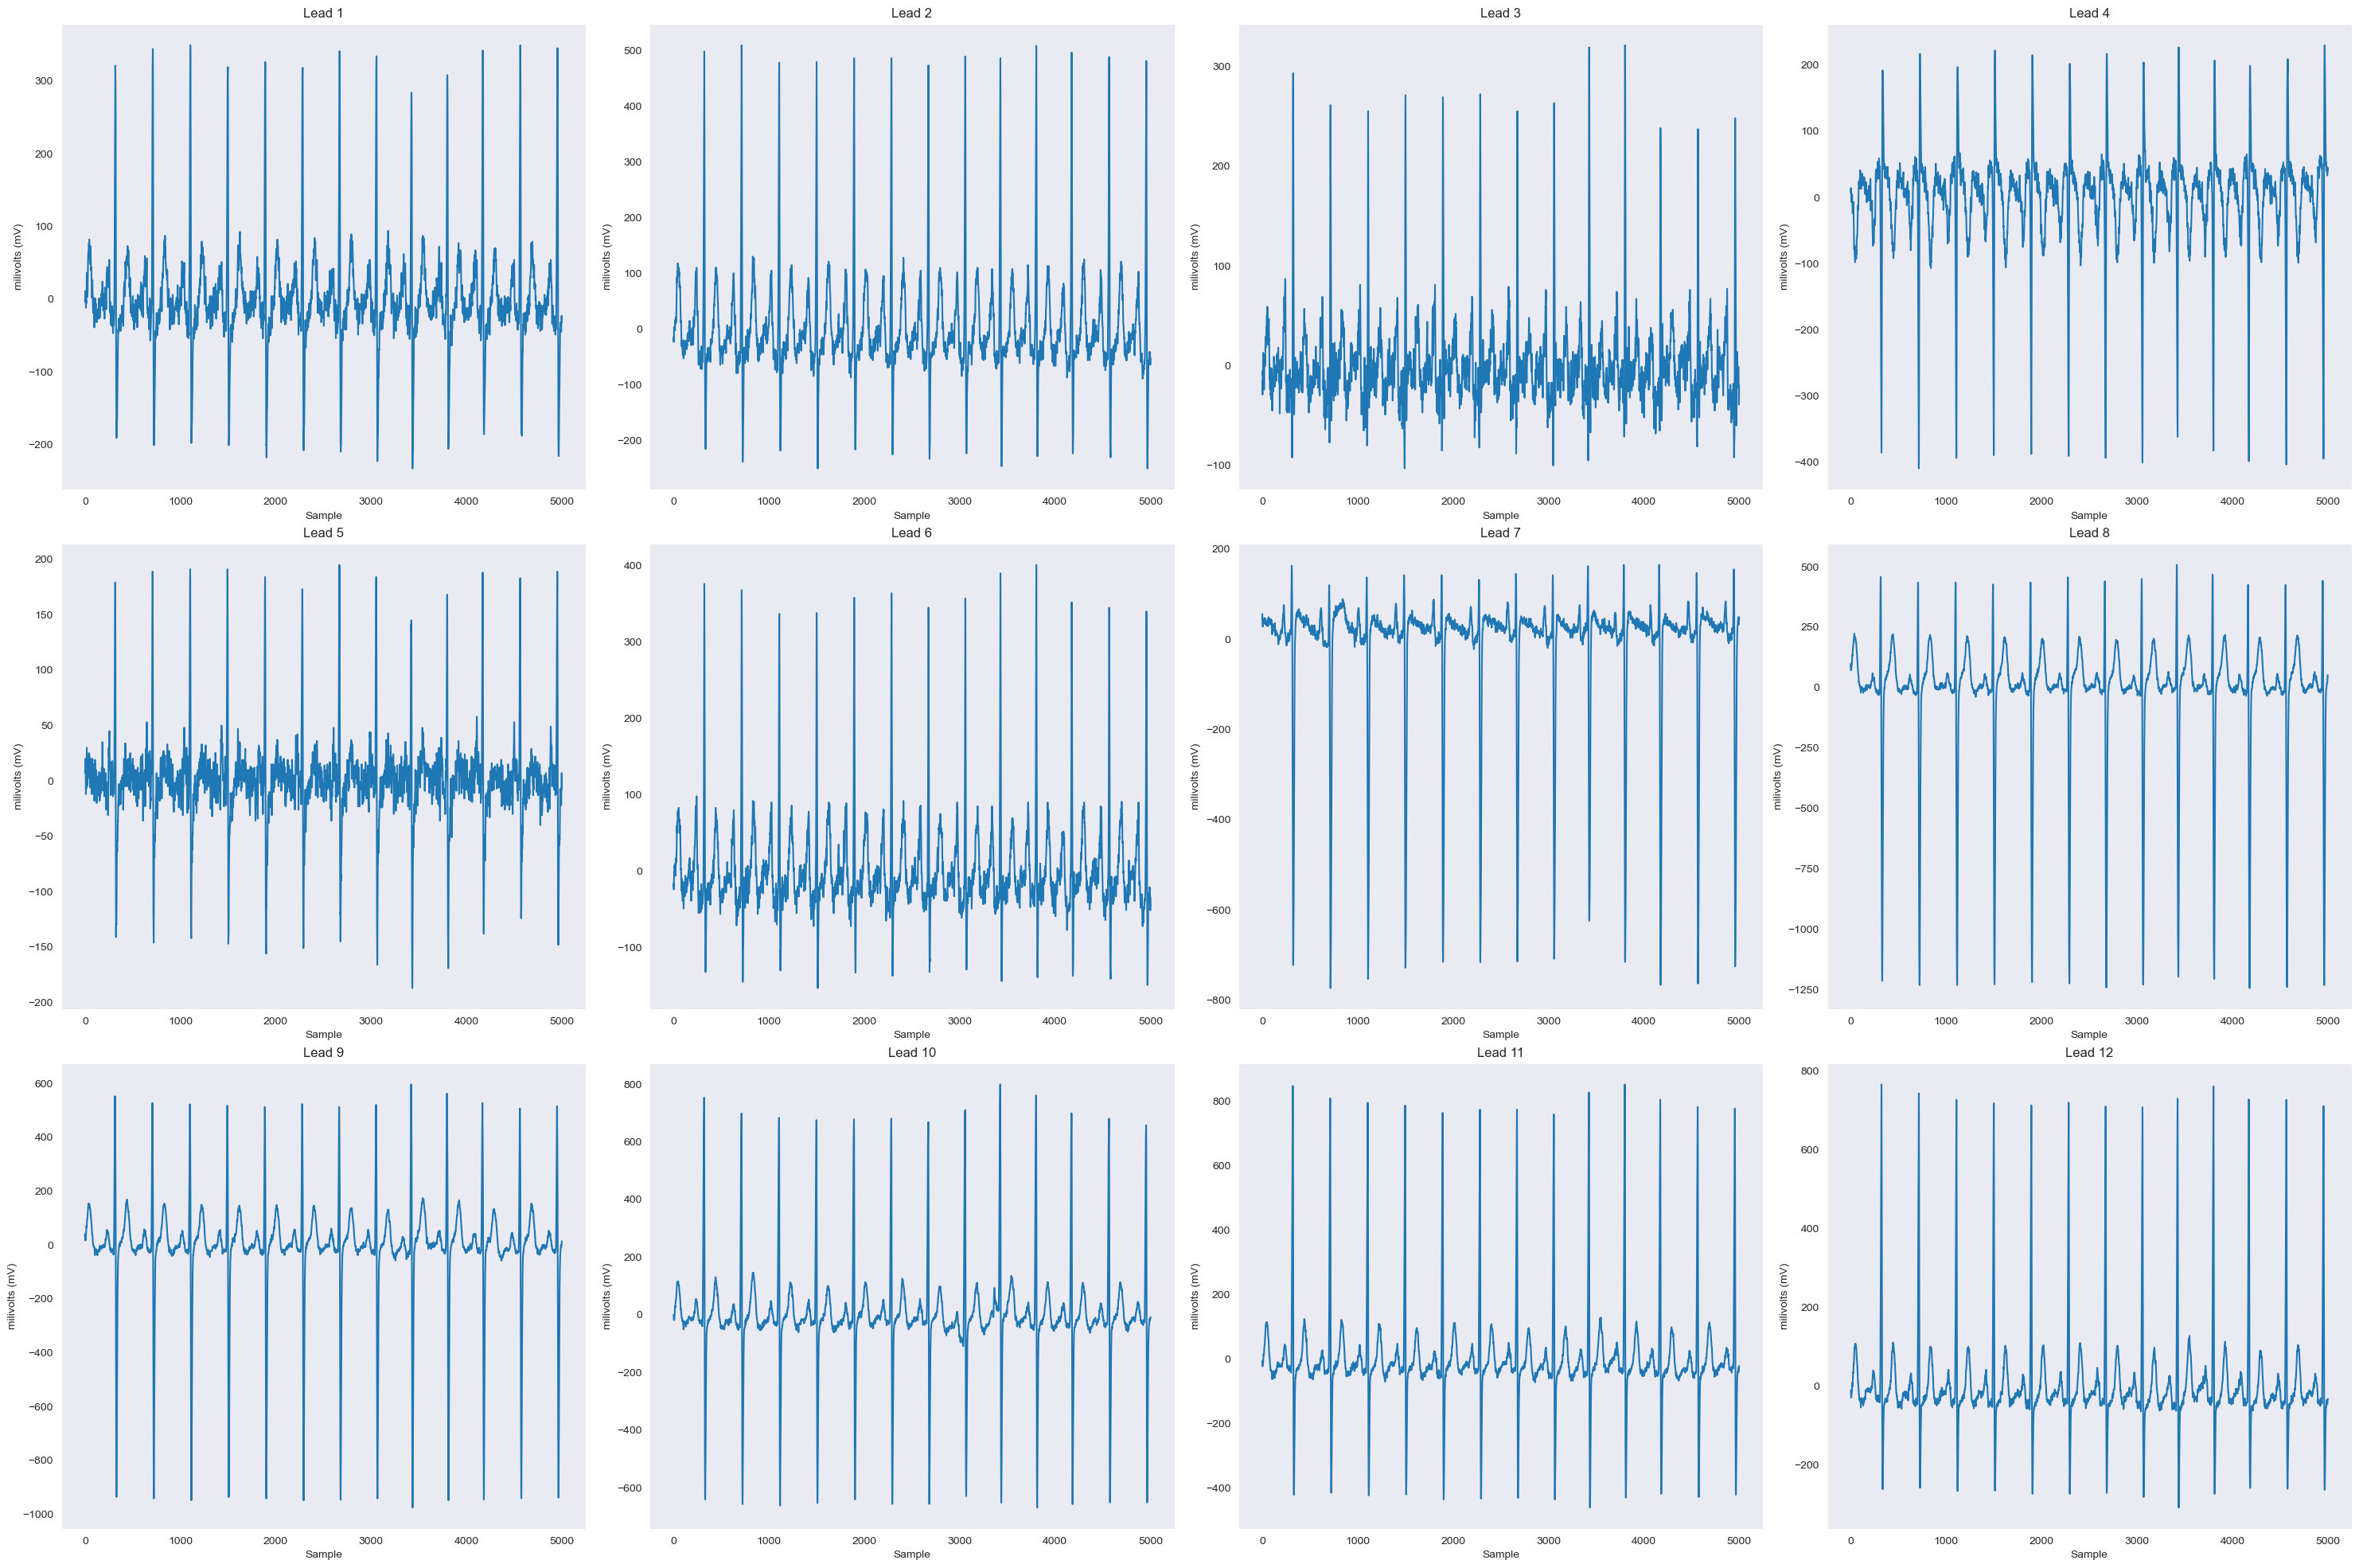

In [13]:
import scipy.io
mat = scipy.io.loadmat('data\A0002.mat')
numpy_array = np.array(list(mat.values()))

# Reshape the array for plotting
time_series_data = numpy_array.reshape(12, numpy_array.shape[2])

fig, axes = plt.subplots(3, 4, figsize=(30, 20))
fig.tight_layout(pad=3.0)

for i, ax in enumerate(axes.flatten()):
    ax.plot(time_series_data[i], label=f'Month {i + 1}')
    ax.set_title(f'Lead {i + 1}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('milivolts (mV)')
#plt.show()
plt.savefig('sample.png')

# Extending the Dataset to fit the GAN and anonymization 

In [11]:
numpy_array[0,0]

array([ -1,  -4,   2, ..., -25, -23, -32], dtype=int16)

In [12]:
filenames = ground_data_filtered["ECG Filenames"].values
print(len(filenames))

21119


In [13]:
from tqdm import tqdm

full_df = pd.DataFrame()

for sampl, filename in enumerate(tqdm(filenames, desc="Processing files")):
    filename = filename.replace("/", "")
    mat = scipy.io.loadmat(filename)
    numpy_array = np.array(list(mat.values()))
    # Convert to df with filename | ts nbr | array

    data = []

    for i in range(12):
        data.append([i + 1, filename, numpy_array[0, i].tolist()])

    result_df = pd.DataFrame(data, columns=['lead', 'file', 'numpy_array'])
    full_df = pd.concat([full_df, result_df])


Processing files: 100%|██████████| 21119/21119 [5:29:44<00:00,  1.07it/s]       


In [14]:
full_df.reset_index(drop=True, inplace=True)
full_df.head(5)

,lead,file,numpy_array
0,1,data\A0002.mat,"[-1, -4, 2, 11, 8, 9, 8, 7, -1, -6, -12, -9, -..."
1,2,data\A0002.mat,"[-15, -23, -18, -19, -8, 4, 2, -3, -1, 4, 2, -..."
2,3,data\A0002.mat,"[-15, -18, -20, -29, -16, -5, -7, -10, 0, 11, ..."
3,4,data\A0002.mat,"[7, 14, 8, 4, 0, -7, -5, -2, 1, 1, 5, 4, -1, 2..."
4,5,data\A0002.mat,"[8, 8, 10, 20, 12, 7, 8, 8, -1, -8, -12, -8, -..."


# Cleaning the Dataset and Merging it with Header Data

In [15]:
from tqdm import tqdm

# Create the ID column using list comprehension
full_df['ID'] = [f"{file.split('/')[-1].split('.')[0]}_lead_{lead}" for file, lead in zip(full_df['file'], full_df['lead'])]

# Extract the numpy arrays from the 'numpy_array' column
numpy_arrays = full_df['numpy_array'].tolist()

# Create a new DataFrame from the list of numpy arrays
expanded_df = pd.DataFrame(numpy_arrays)

# Add the ID column to the new DataFrame
expanded_df.insert(0, 'ID', full_df['ID'])

# Display the new DataFrame
# Limit the DataFrame to 5000 columns
expanded_df = expanded_df.iloc[:, :5000]

# Display the new DataFrame
print("Number of rows with nan values: ")
print(expanded_df.isna().sum(axis=1).sum())

# Update the ID column to remove backslashes
expanded_df['ID'] = [id.split('\\')[-1] for id in tqdm(expanded_df['ID'], desc="Processing IDs")]

Number of rows with nan values: 
0


Processing IDs: 100%|██████████| 253428/253428 [00:00<00:00, 903152.14it/s]


In [86]:
expanded_df.head()

,ID,0,1,2,3,4,5,6,7,8,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,file_merge
0,A0002_lead_1,-1,-4,2,11,8,9,8,7,-1,...,-39,-42,-45,-36,-25,-25,-24,-25,-23,A0002
1,A0002_lead_2,-15,-23,-18,-19,-8,4,2,-3,-1,...,-41,-44,-46,-41,-41,-47,-56,-64,-57,A0002
2,A0002_lead_3,-15,-18,-20,-29,-16,-5,-7,-10,0,...,-2,-2,-1,-5,-17,-22,-32,-39,-34,A0002
3,A0002_lead_4,7,14,8,4,0,-7,-5,-2,1,...,40,44,46,39,33,36,40,45,40,A0002
4,A0002_lead_5,8,8,10,20,12,7,8,8,-1,...,-18,-20,-22,-15,-4,-1,5,7,5,A0002


In [87]:
expanded_df['file_merge'].nunique()

21119

In [71]:
ground_data_filtered.head()

,Age,Gender,Labels,ECG Filenames
0,49,1,426783006,data/\A0002.mat
10,35,1,426783006,data/\A0029.mat
13,42,1,426783006,data/\A0037.mat
14,55,0,426783006,data/\A0038.mat
16,40,1,426783006,data/\A0041.mat


In [74]:
ground_data_filtered['file_merge'] = ground_data_filtered['ECG Filenames'].str.slice(-9, -4)
ground_data_filtered.head()

,Age,Gender,Labels,ECG Filenames,file_merge
0,49,1,426783006,data/\A0002.mat,A0002
10,35,1,426783006,data/\A0029.mat,A0029
13,42,1,426783006,data/\A0037.mat,A0037
14,55,0,426783006,data/\A0038.mat,A0038
16,40,1,426783006,data/\A0041.mat,A0041


In [63]:
expanded_df['file_merge'] = expanded_df['ID'].apply(lambda x: x.split('_')[0])
expanded_df.head()

,ID,0,1,2,3,4,5,6,7,8,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,file_merge
0,A0002_lead_1,-1,-4,2,11,8,9,8,7,-1,...,-39,-42,-45,-36,-25,-25,-24,-25,-23,A0002
1,A0002_lead_2,-15,-23,-18,-19,-8,4,2,-3,-1,...,-41,-44,-46,-41,-41,-47,-56,-64,-57,A0002
2,A0002_lead_3,-15,-18,-20,-29,-16,-5,-7,-10,0,...,-2,-2,-1,-5,-17,-22,-32,-39,-34,A0002
3,A0002_lead_4,7,14,8,4,0,-7,-5,-2,1,...,40,44,46,39,33,36,40,45,40,A0002
4,A0002_lead_5,8,8,10,20,12,7,8,8,-1,...,-18,-20,-22,-15,-4,-1,5,7,5,A0002


In [94]:
ground_data_filtered[ground_data_filtered["file_merge"] == "01771"]

,Age,Gender,Labels,ECG Filenames,file_merge
4319,67,1,426783006,data//JS01771.mat,01771


In [98]:
expanded_df["file_merge"] = expanded_df["file_merge"].str[-5:]


In [99]:
# Merge the dataframes on the 'file_merge' column
merged_data = expanded_df.merge(ground_data_filtered, on='file_merge')

# Display the first few rows of the merged dataframe
merged_data.pop('file_merge')
merged_data.head()

,ID,0,1,2,3,4,5,6,7,8,...,4993,4994,4995,4996,4997,4998,Age,Gender,Labels,ECG Filenames
0,A0002_lead_1,-1,-4,2,11,8,9,8,7,-1,...,-36,-25,-25,-24,-25,-23,49,1,426783006,data//A0002.mat
1,A0002_lead_2,-15,-23,-18,-19,-8,4,2,-3,-1,...,-41,-41,-47,-56,-64,-57,49,1,426783006,data//A0002.mat
2,A0002_lead_3,-15,-18,-20,-29,-16,-5,-7,-10,0,...,-5,-17,-22,-32,-39,-34,49,1,426783006,data//A0002.mat
3,A0002_lead_4,7,14,8,4,0,-7,-5,-2,1,...,39,33,36,40,45,40,49,1,426783006,data//A0002.mat
4,A0002_lead_5,8,8,10,20,12,7,8,8,-1,...,-15,-4,-1,5,7,5,49,1,426783006,data//A0002.mat


In [100]:
label_counts = merged_data['Labels'].value_counts()
print(label_counts)

Labels
426177001    106908
426783006     75012
427084000     38712
164890007     17988
427393009     14808
Name: count, dtype: int64


Visualize to see if the ECG is looking like it should

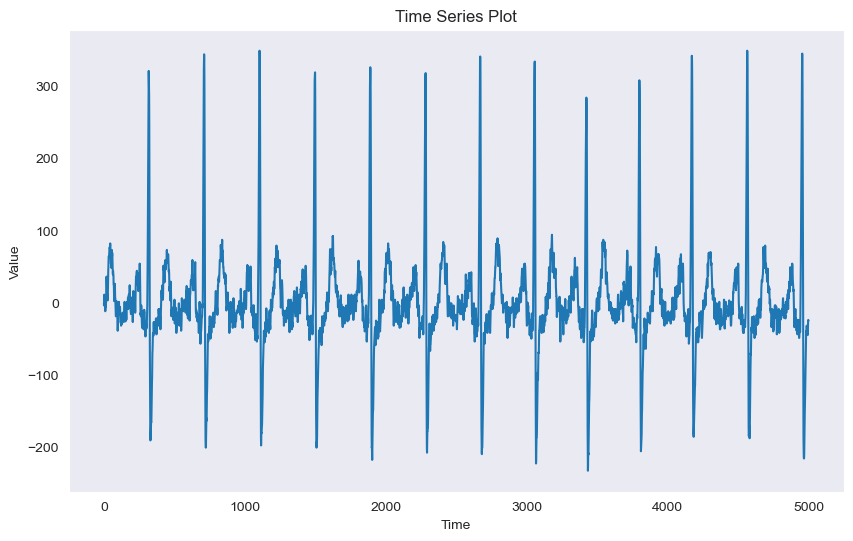

In [101]:
import matplotlib.pyplot as plt

# Extract the first row of merged_data
first_row = merged_data.iloc[0]

# Select the columns from 0 to 4998
time_series_data = first_row.iloc[1:4999]

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(time_series_data)
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Export Dataframe

In [ ]:
import csv

def find_bad_lines(filename):
  """
  Finds lines in a CSV file that have a different number of fields than the first line.

  Args:
    filename: Path to the CSV file.

  Returns:
    A list of line numbers (starting from 1) that are considered "bad".
  """
  with open(filename, 'r') as file:
    reader = csv.reader(file)
    num_fields = len(next(reader))  # Get number of fields from the first line
    bad_lines = []
    for line_num, row in enumerate(reader, start=2):  # Start from line 2
      if len(row) != num_fields:
        bad_lines.append(line_num)
    return bad_lines

In [ ]:
def check_line(filename, line_number):
  """
  Checks a specific line in a CSV file for potential issues.

  Args:
    filename: Path to the CSV file.
    line_number: The line number to check (starting from 1).

  Returns:
    A dictionary containing results of the checks.
  """
  results = {
      "line_number": line_number,
      "num_fields": None,
      "delimiter_issues": False,
      "unescaped_chars": False,
  }

  try:
    with open(filename, 'r') as file:
      reader = csv.reader(file)
      for i in range(line_number - 1):  # Skip to the desired line
        next(reader)
      row = next(reader)
      results["num_fields"] = len(row)

      # Check for delimiter issues (assuming comma as delimiter)
      for field in row:
        if ',' in field and '"' not in field:
          results["delimiter_issues"] = True

      # Check for unescaped special characters (e.g., quotes, newlines)
      for field in row:
        if any(char in field for char in ['"', '\n', '\r']):
          results["unescaped_chars"] = True

  except StopIteration:
    print(f"Line {line_number} does not exist in the file.")

  return results

In [102]:
merged_data.to_csv('ecg_age_dataset.csv', index=False)

In [ ]:
merged_data.to_pickle('ecg_age_dataset.pkl')